# SI with $k\times k$ matrices
Conjecture: $k=2$ enough to capture SI models exactly.

In [4]:
using MatrixProductBP, MatrixProductBP.Models
using IndexedGraphs, Random, ProgressMeter
using Plots
using Graphs, Graphs.SimpleGraphs

In [5]:
function regular_tree(k::T, z::T) where {T<:Integer}
    n = (z^k - 1) ÷ (z - 1)
    ne = n - 1
    fadjlist = Vector{Vector{T}}(undef, n)
    @inbounds fadjlist[1] = convert.(T, 2:(z + 1))
    @inbounds for l in 2:(k - 1)
        w = (z^(l - 1) - 1) ÷ (z - 1)
        x = w + z^(l - 1)
        @simd for i in 1:(z^(l - 1))
            j = w + i
            fadjlist[j] = [
                T(ceil((j - x) / z) + w)
                convert.(T, (x + (i - 1) * z + 1):(x + i * z))
            ]
        end 
    end
    l = k
    w = (z^(l - 1) - 1) ÷ (z - 1)
    x = w + z^(l - 1)
    @inbounds @simd for j in (w + 1):x
        fadjlist[j] = T[ceil((j - x) / z) + w]
    end
    return SimpleGraph(ne, fadjlist)
end

regular_tree (generic function with 1 method)

In [35]:
T = 10
# k = 4   # tree depth
# z = 2   # z-ary tree
# gg = regular_tree(k, z)
N = 10
k = 3
seed = 222
gg = random_regular_graph(N, k; seed)
g = IndexedGraph(gg)
# N = nv(g)

λ = 0.3
ρ = 0.0   # SI
γ = 0.1;

In [43]:
sis = SIS(g, λ, ρ, T; γ)
bp = mpbp(sis)
rng = MersenneTwister(seed)
X, _ = onesample(bp; rng)
draw_node_observations!(bp.ϕ, X, N*(T+1), last_time=false; rng, softinf=2.0)
w_generic = [[GenericFactor(wit) for wit in wi] for wi in bp.w]
bp_generic = mpbp(bp.g, w_generic, fill(2,N), T; ϕ=deepcopy(bp.ϕ));

In [45]:
matrix_sizes = 1:10;

In [46]:
errs_generic = zeros(length(matrix_sizes))
@showprogress for i in eachindex(matrix_sizes)
    sz = matrix_sizes[i]
    svd_trunc = TruncBondMax(sz)
    bp2 = deepcopy(bp_generic)
    for ij in eachindex(bp.μ)
        bp2.μ[ij] = rand_mpem2(2, 2, T; d=sz)
        normalize!(bp2.μ[ij])
    end
    iters, cb = iterate!(deepcopy(bp2), maxiter=1; svd_trunc, showprogress=false, tol=1e-15)
    errs_generic[i] = only(svd_trunc.maxerr)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


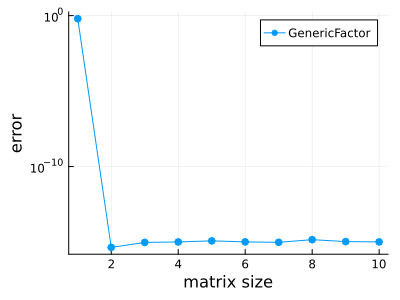

In [47]:
errs_generic_filtered = replace(errs_generic, 0.0=>NaN)
pl = plot(matrix_sizes, errs_generic_filtered, xlabel="matrix size", ylabel="error", label="GenericFactor", 
    m=:o, msc=:auto, yaxis=:log10, size=(400,300))

In [48]:
errs_recursive = zeros(length(matrix_sizes))
@showprogress for i in eachindex(matrix_sizes)
    sz = matrix_sizes[i]
    svd_trunc = TruncBondMax(sz)
    bp2 = deepcopy(bp)
    for ij in eachindex(bp.μ)
        bp2.μ[ij] = rand_mpem2(2, 2, T; d=sz)
        normalize!(bp2.μ[ij])
    end
    iters, cb = iterate!(deepcopy(bp2), maxiter=1; svd_trunc, showprogress=false, tol=1e-15)
    errs_recursive[i] = only(svd_trunc.maxerr)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


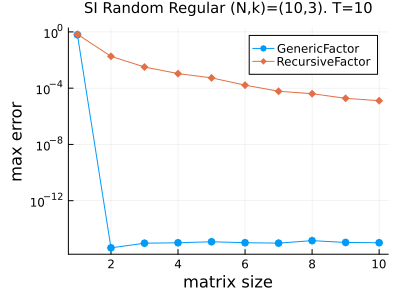

In [49]:
errs_recursive_filtered = replace(errs_recursive, 0.0=>NaN)
plot!(deepcopy(pl), matrix_sizes, errs_recursive_filtered, xlabel="matrix size", ylabel="max error", 
    label="RecursiveFactor", yticks=10.0 .^ (-16:4:0), msc=:auto,
    m=:diamond, yaxis=:log10, title="SI Random Regular (N,k)=($N,$k). T=$T", titlefontsize=10)

In [116]:
T = 3
N = 5
k = 4
seed = 222
gg = random_regular_graph(N, k; seed)
g = IndexedGraph(gg)

λ = 0.3
ρ = 0.0   # SI
γ = 0.1;

In [117]:
sis = SIS(g, λ, ρ, T; γ)
bp = mpbp(sis)
rng = MersenneTwister(seed)
X, _ = onesample(bp; rng)
draw_node_observations!(bp.ϕ, X, N*(T+1), last_time=false; rng, softinf=2.0)
w_generic = [[GenericFactor(wit) for wit in wi] for wi in bp.w]
bp_generic = mpbp(bp.g, w_generic, fill(2,N), T; ϕ=deepcopy(bp.ϕ));

In [118]:
sz = 5
svd_trunc = TruncBondMax(10)
bp2 = deepcopy(bp_generic)
for ij in eachindex(bp.μ)
    bp2.μ[ij] = rand_mpem2(2, 2, T; d=sz)
    normalize!(bp2.μ[ij])
end

In [119]:
A = bp2.μ[1]

MPEM2{Float64}([[0.0185123262095475 0.02286962987252721 … 0.11828637305368435 0.02447262511134215;;; 0.04306983287910532 0.03781430532330562 … 0.05472167700121063 0.03371372521638061;;;; 0.11447712975049149 0.04424646229011221 … 0.08390000277851191 0.05863766387792166;;; 0.13729744072029149 0.08595103644624308 … 0.1427941467420609 0.024474889824645463], [0.10023856708293648 0.024278081476012407 … 0.09683129134452816 0.018694562262383772; 0.09858308823665789 0.03878137353875753 … 0.08302196954329288 0.14057460516872106; … ; 0.10959642375015326 0.09192298633615519 … 0.06975809810459166 0.048040266170944014; 0.046739603918919 0.020102592207066675 … 0.04318366430041997 0.14047492723502383;;; 0.048852540396439804 0.0706731316500785 … 0.0876775810508251 0.139740176016531; 0.13840174839835914 0.10059637086450994 … 0.05702301593361343 0.011796393545497318; … ; 0.12564864718828544 0.06052013999089909 … 0.06950408684881078 0.004384713604069937; 0.08632958279235689 0.08889935677160987 … 0.0176117

In [120]:
iters, cb = iterate!(bp2, maxiter=1; svd_trunc, showprogress=false, tol=1e-15)
only(svd_trunc.maxerr)

9.974071919608948e-33

In [121]:
A = deepcopy(bp2.μ[1])
svd_trunc = TruncThresh(1e-15)
compress!(A; svd_trunc);

In [122]:
A |> bond_dims

3-element Vector{Int64}:
 2
 2
 2

In [81]:
bp2.μ[1]

MPEM2{Float64}([[0.5084716886075663 -0.01752034412668769 -2.89275227546139e-18 -9.419106819626592e-21;;; 0.0009947459788043666 0.010430008746310651 -6.582633753778808e-18 -3.1404294589987485e-19;;;; 0.3594580396954648 0.024725691354945956 4.132503250659129e-18 1.3455866885180846e-20;;; 0.0009947459788043757 0.010430008746310651 -8.073251869761213e-18 2.6632183497193155e-19], [-0.5084716886075663 0.03108540406234659 … -8.949008976402406e-23 -1.139367017639824e-26; 0.04849470215038516 -0.002964722412286379 … 1.345067488727415e-21 2.2938672402460805e-24; 0.011709499860869645 -0.47251032646996205 … -2.339695518831183e-6 2.6116510167035756e-7; 0.04087162076194923 0.1834193216657623 … -2.7216140558924703e-5 1.8315282300631777e-7;;; -0.007614123451183982 -0.041755268185529326 … -6.499449544890008e-22 -5.578763528874033e-26; -0.07983482807016795 -0.43780806523397275 … 1.9488301664309568e-20 1.662147622767822e-24; 0.13794934549924104 -0.013045088420811802 … 2.8286035056877872e-5 2.4408550357676

In [54]:
svd_trunc = TruncBondMax(1)
compress!(deepcopy(A); svd_trunc)
svd_trunc

SVD truncation to bond size m'=1. Max error 0.0


In [55]:
A

MPEM2{Float64}([[0.3732565959286356;;; 0.07273587671913243;;;; 0.35474484136315837;;; 0.15524034300766293], [0.3732565959286356;;; 0.33480186074020235;;;; 0.006219254704286857;;; 0.22880982664785163], [0.12483154281802679;;; 0.3732565959286356;;;; 0.3634308928253073;;; 0.047991397832830095], [0.2648552507831887;;; 0.22370380861372324;;;; 0.3732565959286356;;; 0.35771456928413425]])

In [22]:
using LinearAlgebra
reshape(bp2.μ[1][1], 10,4)' |> svd

SVD{Float64, Float64, Adjoint{Float64, Matrix{Float64}}, Vector{Float64}}
U factor:
4×4 adjoint(::Matrix{Float64}) with eltype Float64:
 -0.552286   0.0992407  -0.487391  -0.669015
 -0.545038  -0.472217    0.682744  -0.117501
 -0.341063   0.859132    0.348622   0.155019
 -0.530651  -0.170454   -0.41806    0.717343
singular values:
4-element Vector{Float64}:
 0.30589396981334105
 0.09711973860572574
 0.06909867397012617
 0.055822670963708965
Vt factor:
4×10 adjoint(::Matrix{Float64}) with eltype Float64:
 -0.397489  -0.255637    -0.492895   …  -0.204202  -0.349306  -0.367697
 -0.232061  -0.102763     0.0843848     -0.140495  -0.245286   0.404863
 -0.158973   0.426697    -0.142725       0.319147   0.149083  -0.405425
 -0.130943   0.00591218   0.0530518     -0.252754   0.251715   0.471876